In [115]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import torch
import matplotlib.pyplot as plt

In [116]:
path = "/Users/abhishekpatnaik/Downloads/quora-question-pairs/train.csv"

In [117]:
df = pd.read_csv(path)

In [118]:
df.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


In [119]:
idx = 404286
print(df.question1.loc[idx],df.question2.loc[idx])

Do you believe there is life after death? Is it true that there is life after death?


In [120]:
# lets see how duplicate questions looks like
duplicate = df[df['is_duplicate'] == 1] 

In [121]:
duplicate = duplicate.reset_index()
duplicate.head(5)

,index,id,qid1,qid2,question1,question2,is_duplicate
0,5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
1,7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
2,11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
3,12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
4,13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [122]:
idx = 5
print(duplicate.question1.loc[idx],duplicate.question2.loc[idx])

What would a Trump presidency mean for current international master’s students on an F1 visa? How will a Trump presidency affect the students presently in US or planning to study in US?


In [123]:
# Now lets see how different questions looks like
diff = df[df['is_duplicate'] == 0]
diff = diff.reset_index()

In [124]:
diff.head()

,index,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
idx = 10
print(diff.question1.loc[idx],diff.question2.loc[idx])

In [ ]:
# the very first method that came to my mind was sentence similarity


In [125]:
from gensim.models import Word2Vec

In [126]:
tokenized_sentences1 = diff.question1.loc[10].split()
tokenized_sentences2 = diff.question2.loc[10].split()
model1 = Word2Vec(tokenized_sentences1,min_count=1)
model2 = Word2Vec(tokenized_sentences2,min_count=1)

In [127]:
tokenized_sentences1, tokenized_sentences2

(['Why',
  'do',
  'girls',
  'want',
  'to',
  'be',
  'friends',
  'with',
  'the',
  'guy',
  'they',
  'reject?'],
 ['How', 'do', 'guys', 'feel', 'after', 'rejecting', 'a', 'girl?'])

In [128]:
def get_cosine(vec1, vec2):
        intersection = set(vec1.keys()) & set(vec2.keys())
        numerator = sum([vec1[x] * vec2[x] for x in intersection])

        sum1 = sum([vec1[x]**2 for x in vec1.keys()])
        sum2 = sum([vec2[x]**2 for x in vec2.keys()])
        denominator = math.sqrt(sum1) * math.sqrt(sum2)

        if not denominator:
            return 0.0
        else:
            return float(numerator) / denominator

def review_to_wordlist(review, remove_stopwords=False):
    """
    Convert a review to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words        

In [129]:
from gensim.models.keyedvectors import KeyedVectors
model =  KeyedVectors.load_word2vec_format('/Users/abhishekpatnaik/Downloads/GoogleNews-vectors-negative300.bin', binary=True)


/Users/abhishekpatnaik/miniconda3/envs/env1/lib/python3.5/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
from nltk.corpus import stopwords
import nltk
stop_words = set(stopwords.words('english')) 
#filtered_sentence = [w for w in tokenized_sentences1 if not w in stop_words]
list_1 = [[x for x in review_to_wordlist(duplicate.question1.loc[13]) if x not in stop_words]]
list_2 = [[x for x in review_to_wordlist(duplicate.question2.loc[13]) if x not in stop_words]]
print(list_1)
vectors1 = [model[w] for w in list_1]
vectors2 = [model[w] for w in list_2]

In [ ]:
question1 = [review_to_wordlist(str(x)) for x in df.question1]

In [ ]:
question2 = [review_to_wordlist(str(x)) for x in df.question2]

In [ ]:
label = [x for x in df.is_duplicate]

In [ ]:
len(label)

In [ ]:
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 3       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3
model = word2vec.Word2Vec(question1+question2, workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling)

In [ ]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0.
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1.
    return review_feature_vecs

In [ ]:
# calculate average feature vectors for training and test sets
clean_train_reviews = []
for review in df.question1:
    clean_train_reviews.append(review_to_wordlist(str(review), remove_stopwords=True))
trainDataVecs = get_avg_feature_vecs(clean_train_reviews, model, num_features)


In [ ]:
# infersent


In [ ]:
mkdir encoder

In [ ]:
# trained on Glove
# Run only if there's no infersent encoder

In [ ]:
! curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl

In [ ]:
# trained on fasttext

In [ ]:
mkdir fasttext

In [ ]:
! curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abhishekpatnaik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
from models import InferSent

In [11]:
V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [12]:
W2V_PATH = 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [13]:
model.build_vocab_k_words(K=100000)

Vocab size : 100000


In [ ]:
mkdir fastText

In [ ]:
! curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip    

In [ ]:
! unzip fastText/crawl-300d-2M.vec.zip -d fastText/

In [39]:
sentences = []
for idx,ele in df.iterrows():
        sentences.append(str(ele['question1']))
  #      sentences.append(str(ele['question2']))

In [ ]:
sentences

In [ ]:
embeddings = model.encode(sentences[:1000], bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))


In [ ]:
# np.linalg.norm(model.encode(['the cat eats.']))

In [14]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


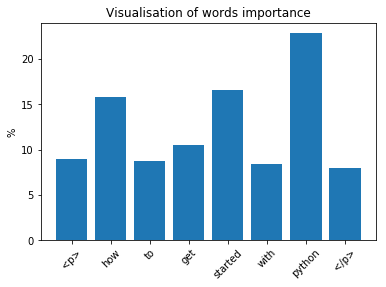

In [45]:
_, _ = model.visualize('how to get started with python')

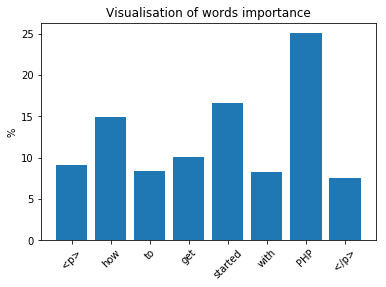

In [44]:
_, _ = model.visualize('how to get started with PHP')

In [68]:
idx=20
print(duplicate.question1.loc[idx],duplicate.question2.loc[idx])
cosine(model.encode([duplicate.question1.loc[idx]])[0], model.encode([duplicate.question2.loc[idx]])[0])

What is Java programming? How To Learn Java Programming Language ? How do I learn a computer language like java?


0.67294335

In [69]:
# unsupervised way for classification

In [110]:
similarity_score = []
question1 = []
question2 = []
answer = []
for idx in range(len(df)):
    if idx%500 == 0:
        print(idx)
    if idx <= 2000:

        if (cosine(model.encode([df.question1.loc[idx]])[0], model.encode([df.question2.loc[idx]])[0])) > 78:
            similarity_score.apppend("1")
        else:
            similarity_score.append("0")

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
8500

In [91]:
dataframe_score = pd.DataFrame({"similarity_score":similarity_score,"question1":question1,"question2":question2,"answer":answer})

In [92]:
dataframe_score.to_csv("without_training_word_vector.csv",index=False)

In [93]:
score = []
count = 0
for i in range(len(dataframe_score)):
        if str(dataframe_score['answer'].loc[i]) == dataframe_score['similarity_score'].loc[i]:
            count+=1

In [95]:
count/2000

0.6295

In [100]:
path = "/Users/abhishekpatnaik/Downloads/quora-question-pairs/test.csv"

In [ ]:
path = pd.read_csv(path)